In [1]:
%matplotlib inline

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer


pd.set_option('display.max_colwidth', 120)

In [107]:
un_df = pd.read_json('data/un-general-debates.json')
print(len(un_df))

7507


In [108]:
un_df.sample(5)

,country_code,speech_text,speech_year
1716,SWZ,﻿It is an immense pleasure for me\nto join other Heads of State and Government at this\nsixty-seventh session of the...,2012
1669,AGO,"﻿On behalf\nof the Government of the Republic of Angola, I avail\nmyself of this opportunity to congratulate Mr. Vuk...",2012
1416,NIC,﻿Allow me to begin by congratulating the President on his\nelection to preside over the Assembly this session. We ar...,1996
6092,LCA,"Humanity, our greatest\nconcern, is the reason why we are gathered here today.\nHumanity stands at a defining moment...",2000
3073,BEL,"Mr. President, I hope that you will convey to the President of the Assembly that we are extremely honored at his ele...",1976


<div class="alert alert-info">
<h3> Your turn</h3>
<p> As a group, take a look at the text of the UN speeches. When delivering an address, what are the different topics that are covered? Make a list of four topics and provide three example words from each topic.
</div> 




![](images/lda.jpg)

In [105]:
from sklearn.decomposition import LatentDirichletAllocation

In [112]:
vectorizer = CountVectorizer(lowercase   = True,
                             ngram_range = (1,1),
                             max_df      = .90,
                             stop_words   = 'english',
                             max_features = 1000)

In [113]:
vectorizer.fit(un_df['speech_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=1000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [114]:
len(vectorizer.get_feature_names())

1000

In [115]:
un_word_counts = vectorizer.transform(un_df['speech_text'])

In [117]:
lda_model = LatentDirichletAllocation(n_components = 10,
                                      max_iter     = 50,
                                      n_jobs       = -1,
                                      verbose      = 1)

In [118]:
lda_model.fit(un_word_counts)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

## Some fit statistics

In [120]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(un_word_counts))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(un_word_counts))

Log Likelihood:  -36142963.39734339
Perplexity:  685.2293725427917


## Guidelines on topic fit
1. Low perplexity on test data.
1. Topical coherence
2. Best fit in a classification task.
3. Extract more and then bin them yourself. 

In [121]:
print(lda_model.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 50, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 1}


In [198]:
from pdtext.tm import topic_words

topic_words(lda_model, vectorizer).head(10)


,1,2,3,4,5,6,7,8,9,10
Topic 1,developing,south,trade,developed,problems,resources,debt,growth,global,africa
Topic 2,human,today,war,years,time,terrorism,let,rights,future,freedom
Topic 3,peoples,social,government,america,order,republic,american,national,rights,respect
Topic 4,nuclear,weapons,soviet,disarmament,republic,relations,war,arms,treaty,union
Topic 5,global,change,climate,small,sustainable,developing,goals,challenges,island,government
Topic 6,africa,south,independence,peoples,namibia,struggle,african,government,regime,non
Topic 7,israel,arab,palestinian,region,iraq,resolutions,council,lebanon,israeli,middle
Topic 8,human,rights,council,cooperation,process,member,role,important,reform,global
Topic 9,africa,african,government,republic,situation,like,national,mr,conflict,president
Topic 10,problems,operation,government,time,great,human,rights,hope,charter,conference


In [123]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

In [197]:
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(lda_model, un_word_counts, vectorizer, mds='tsne')
#panel

<div class="alert alert-info">
<h3> Your turn</h3>
<p> In your group, do 1 and 2 in 10_Topic_Modeling_group
</div> 





## What documents are associated with what topics?

In [126]:
from pdtext.tm import topic_pred

In [130]:
un_topics = topic_pred(lda_model, un_word_counts, vectorizer)

In [131]:
un_topics

,developing_south_trade,human_today_war,peoples_social_government,nuclear_weapons_soviet,global_change_climate,africa_south_independence,israel_arab_palestinian,human_rights_council,africa_african_government,problems_operation_government
0,0.301417,0.000126,0.000126,0.123103,0.125208,0.098048,0.172829,0.005017,0.078136,0.095991
1,0.270243,0.000132,0.000132,0.030607,0.072022,0.000132,0.025798,0.276099,0.000132,0.324704
2,0.107989,0.031339,0.102842,0.078691,0.000076,0.161911,0.065419,0.000076,0.328185,0.123472
3,0.293397,0.067417,0.414592,0.006980,0.000144,0.028637,0.049319,0.022536,0.006639,0.110339
4,0.251379,0.030322,0.000089,0.060589,0.000089,0.317255,0.000089,0.000089,0.214598,0.125502
5,0.487231,0.290527,0.000218,0.038260,0.000218,0.000218,0.000218,0.000218,0.078582,0.104311
6,0.219159,0.000121,0.000121,0.050204,0.000121,0.184625,0.240189,0.000121,0.264310,0.041030
7,0.067663,0.205348,0.071820,0.434893,0.000081,0.000081,0.000081,0.043781,0.000081,0.176169
8,0.078400,0.000091,0.068496,0.503846,0.000091,0.055677,0.116371,0.000091,0.067810,0.109128
9,0.181515,0.000075,0.100028,0.088061,0.000075,0.024280,0.066087,0.157928,0.120831,0.261120


We can now use our topics as features

In [176]:
un_df['post_soviet'] = un_df['speech_year'] > 1991



In [184]:
un_topics.groupby(un_df['post_soviet']).mean()

,developing_south_trade,human_today_war,peoples_social_government,nuclear_weapons_soviet,global_change_climate,africa_south_independence,israel_arab_palestinian,human_rights_council,africa_african_government,problems_operation_government
post_soviet,,,,,,,,,,
False,0.120467,0.052985,0.097623,0.109515,0.013278,0.181575,0.081684,0.043870,0.058654,0.240350
True,0.066035,0.153496,0.083330,0.033451,0.169678,0.013872,0.064622,0.238635,0.122577,0.054304


In [185]:
un_topics.groupby(un_df['post_soviet']).mean().T

post_soviet,False,True
developing_south_trade,0.120467,0.066035
human_today_war,0.052985,0.153496
peoples_social_government,0.097623,0.083330
nuclear_weapons_soviet,0.109515,0.033451
global_change_climate,0.013278,0.169678
africa_south_independence,0.181575,0.013872
israel_arab_palestinian,0.081684,0.064622
human_rights_council,0.043870,0.238635
africa_african_government,0.058654,0.122577
problems_operation_government,0.240350,0.054304


In [186]:
%matplotlib inline

import pandas as pd
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation



In [189]:
lr_classifier = LogisticRegression(solver = 'lbfgs', max_iter= 5000)


In [191]:
lr_classifier.fit(un_topics, un_df['post_soviet'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [192]:
prediction = lr_classifier.predict(un_topics)

In [193]:
print(accuracy_score(un_df['post_soviet'], prediction))



0.9641667776741708


In [195]:
print(classification_report(un_df['post_soviet'], prediction))

              precision    recall  f1-score   support

       False       0.96      0.95      0.96      3048
        True       0.97      0.97      0.97      4459

    accuracy                           0.96      7507
   macro avg       0.96      0.96      0.96      7507
weighted avg       0.96      0.96      0.96      7507



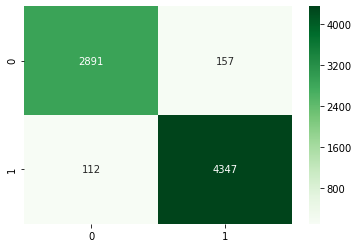

In [196]:
import seaborn as sns

cm = confusion_matrix(un_df['post_soviet'], prediction)
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')

<div class="alert alert-info">
<h3> Your turn</h3>
<p> In your group, do the rest of 10_Topic_Modeling_group
</div> 



